In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from keras.layers.core import Dense, Activation

import re
import csv
from string import punctuation
import nltk 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
import numpy as np
import pandas as pd
                                                 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:


#RÉCUPÉRATION DES TAGS
f=open("/data_task3/train.txt", "r")
data=[]
contents =[line for line in f.readlines() if line.strip()]
indx=0
for x in contents:
    words=x.split()
    if words[0]=="SAMPLE_START":
         indx+=1
    data.append([indx,words[0],words[1]])
data= pd.DataFrame(data, columns=['sentence', 'word', 'tag'])
print (data.head(60))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
    sentence          word            tag
0          1  SAMPLE_START              O
1          1   KRISHNAGIRI              O
2          1             /              O
3          1    DHARMAPURI              O
4          1             :              O
5          1         Water              O
6          1        supply              O
7          1     disrupted              O
8          1             ,              O
9          1     villagers  B-participant
10

In [0]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

print(words)
print(tags)

['Stadium', 'dastardly', 'raids', 'minorities', 'rallies', 'Md.', 'Chowdhury', 'KOZHIKODE', 'GVK-EMRI', 'position', 'Residents', 'hand-chopping', 'outfit', 'amicable', 'local', 'Auxiliary', 'boarded', 'up', 'stalemate', 'broadcasting', 'allegation', 'Evicted', '5', 'relay', 'Mahadev', 'property', 'October', 'fisticuffs', 'Kanwaldeep', 'Fest', 'Rane', 'device', 'deployments', 'consciousness', 'rifles', 'credence', 'detained', 'discovery', 'PFI', 'surge', 'Majumder', 'view', 'desecration', 'communicable', 'Eanchakkal', 'Association', 'zindabad', 'colleagues', 'wore', 'Darjeeling', 'custody', 'domestic', 'Ladoora', 'lorries', 'reading', 'meeting', 'been', 'presided', 'Spot', 'Love', 'Raids', 'Talks', 'Row', 'gun', 'ascended', 'his', 'Agra', 'medals', 'official', 'contractual', 'conservancy', 'extended', 'minutes', 'commissioned', 'long', 'fire', 'Kisan', 'Muktsar', 'Nine', 'pollution', 'experience', 'MNCs', 'office', 'Patna-bound', 'Akhil', 'PHOTO', 'Roopanwal', 'attitude', 'apologise', '

In [0]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                       
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(data)
sentences = getter.sentences    
print(sentences)

[[('SAMPLE_START', 'O'), ('KRISHNAGIRI', 'O'), ('/', 'O'), ('DHARMAPURI', 'O'), (':', 'O'), ('Water', 'O'), ('supply', 'O'), ('disrupted', 'O'), (',', 'O'), ('villagers', 'B-participant'), ('block', 'B-trigger'), ('road', 'B-loc'), ('September', 'O'), ('04', 'O'), (',', 'O'), ('2014', 'O'), ('00:00', 'O'), ('IST', 'O'), ('Officials', 'O'), ('promise', 'O'), ('to', 'O'), ('supply', 'O'), ('water', 'O'), ('in', 'O'), ('tankers', 'O'), ('Women', 'B-participant'), ('took', 'B-trigger'), ('to', 'I-trigger'), ('streets', 'I-trigger'), ('carrying', 'O'), ('pots', 'O'), ('in', 'O'), ('protest', 'O'), ('against', 'O'), ('erratic', 'O'), ('supply', 'O'), ('of', 'O'), ('drinking', 'O'), ('water', 'O'), ('at', 'O'), ('Kelamagalam', 'B-place'), ('in', 'O'), ('Udhanapalli', 'B-place'), ('on', 'B-etime'), ('Wednesday', 'I-etime'), ('.', 'O'), ('[SEP]', 'O'), ('The', 'O'), ('protesters', 'B-participant'), ('blocked', 'B-trigger'), ('the', 'O'), ('Rayakottai', 'B-fname'), ('road', 'I-fname'), ('.', 'O'

In [0]:
lensent= [len(i) for i in sentences]
from statistics import mean 
print (mean(lensent))

85.30333333333333


In [0]:
#max_len = max([len(s) for s in sentences])
max_len=200
print ('Maximum sequence length:', max_len)

Maximum sequence length: 200


In [0]:
max_len = 200
word2idx = {"PAD": 0, "UNK": 1}
word2idx.update({w: i for i, w in enumerate(words) if w in words})
tag2idx = {t: i for i, t in enumerate(tags)}

In [0]:
print(word2idx)

{'PAD': 0, 'UNK': 1, 'Stadium': 0, 'dastardly': 1, 'raids': 2, 'minorities': 3, 'rallies': 4, 'Md.': 5, 'Chowdhury': 6, 'KOZHIKODE': 7, 'GVK-EMRI': 8, 'position': 9, 'Residents': 10, 'hand-chopping': 11, 'outfit': 12, 'amicable': 13, 'local': 14, 'Auxiliary': 15, 'boarded': 16, 'up': 17, 'stalemate': 18, 'broadcasting': 19, 'allegation': 20, 'Evicted': 21, '5': 22, 'relay': 23, 'Mahadev': 24, 'property': 25, 'October': 26, 'fisticuffs': 27, 'Kanwaldeep': 28, 'Fest': 29, 'Rane': 30, 'device': 31, 'deployments': 32, 'consciousness': 33, 'rifles': 34, 'credence': 35, 'detained': 36, 'discovery': 37, 'PFI': 38, 'surge': 39, 'Majumder': 40, 'view': 41, 'desecration': 42, 'communicable': 43, 'Eanchakkal': 44, 'Association': 45, 'zindabad': 46, 'colleagues': 47, 'wore': 48, 'Darjeeling': 49, 'custody': 50, 'domestic': 51, 'Ladoora': 52, 'lorries': 53, 'reading': 54, 'meeting': 55, 'been': 56, 'presided': 57, 'Spot': 58, 'Love': 59, 'Raids': 60, 'Talks': 61, 'Row': 62, 'gun': 63, 'ascended': 6

In [0]:
print(tag2idx)

{'B-trigger': 0, 'B-fname': 1, 'B-etime': 2, 'I-fname': 3, 'B-organizer': 4, 'B-loc': 5, 'I-loc': 6, 'I-place': 7, 'I-participant': 8, 'O': 9, 'I-organizer': 10, 'B-place': 11, 'B-participant': 12, 'I-target': 13, 'B-target': 14, 'I-trigger': 15, 'I-etime': 16}


In [0]:
X = [[word2idx.get(w[0], word2idx["UNK"]) for w in s] for s in sentences]
print (X[0:3])

[[486, 1032, 3737, 1963, 1129, 3230, 5102, 3581, 1664, 4836, 632, 2090, 1204, 2309, 1664, 1540, 1315, 2958, 3360, 4200, 2334, 5102, 1959, 1366, 2235, 2070, 3255, 2334, 4149, 371, 3692, 1366, 1979, 3028, 3926, 5102, 3371, 868, 1959, 3107, 2210, 1366, 1677, 2174, 4548, 3400, 1418, 1406, 4544, 1892, 4114, 3761, 2090, 3400], [486, 2185, 3479, 4134, 1664, 5057, 590, 1129, 38, 2960, 2052, 1664, 2410, 1315, 2958, 2028, 2969, 3935, 1129, 2447, 3371, 1631, 2214, 4809, 4765, 1366, 801, 3575, 4825, 2358, 4114, 3846, 4581, 3371, 2963, 313, 3371, 4351, 1366, 3288, 3371, 4114, 2227, 2060, 3338, 82, 572, 2174, 1334, 4420, 4114, 1908, 1013, 2334, 1528, 399, 436, 3188, 3028, 4114, 4867, 3371, 4114, 582, 1642, 170, 1664, 3257, 3108, 1664, 591, 65, 4484, 3400], [486, 2392, 1299, 1979, 882, 488, 3179, 1129, 4568, 1352, 1087, 2174, 801, 3575, 2174, 3115, 1366, 3288, 3371, 4114, 3619, 1453, 82, 5109, 1560, 2273, 4663, 2559, 1664, 1028, 1664, 591, 3731, 2651, 2334, 4662, 4114, 284, 3371, 43, 1627, 1366, 4114

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"])
print (X[0:3])
print(type(X))


[[ 486 1032 3737 1963 1129 3230 5102 3581 1664 4836  632 2090 1204 2309
  1664 1540 1315 2958 3360 4200 2334 5102 1959 1366 2235 2070 3255 2334
  4149  371 3692 1366 1979 3028 3926 5102 3371  868 1959 3107 2210 1366
  1677 2174 4548 3400 1418 1406 4544 1892 4114 3761 2090 3400    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [0]:
from keras.preprocessing.sequence import pad_sequences
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx["O"])
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print(tag2idx)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",truncating="post", value=tag2idx["I-place"])
print(type(y))
y[1]

9
{'B-trigger': 0, 'B-fname': 1, 'B-etime': 2, 'I-fname': 3, 'B-organizer': 4, 'B-loc': 5, 'I-loc': 6, 'I-place': 7, 'I-participant': 8, 'O': 9, 'I-organizer': 10, 'B-place': 11, 'B-participant': 12, 'I-target': 13, 'B-target': 14, 'I-trigger': 15, 'I-etime': 16}
<class 'numpy.ndarray'>


array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 12,  9,  9,  9,  9,  9,  9,  9,  0,  9,  9,  9,  4, 10, 10,
       10, 10, 10, 10,  5,  6,  6,  6,  6,  6,  6,  6,  9,  2, 16,  9,  9,
       14, 13,  9,  9,  9,  9,  9,  9,  9, 14,  9,  9, 14, 13, 13,  9, 14,
       13,  9,  9,  9, 14,  9,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7], dtype=int32)

Compute class weights

In [0]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(np.ravel(y,order='C')),
                                                 np.ravel(y,order='C'))
print(class_weights)

[ 3.77881345 27.57352941 14.23149905  9.38673342  8.56653341 25.39145154
 13.4198166   0.09853188 21.78649237  0.18665248  7.67263427 11.06398672
  5.54067781 15.34526854  9.41176471 12.60504202 11.45912911]


In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=2018)


In [0]:
print(len(X_tr))
print(y_tr.shape)


210
(210, 200)


MOdel

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-3hggj0if
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-3hggj0if
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=7a28e66a13a3d16c91f5c377cbc2aa5bd56f4fa2660eec1e1dfedd4118fdff15
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4dck51z/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           258600    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 200)          120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 17)           3417      
Total params: 382,817
Trainable params: 382,817
Non-trainable params: 0
________________________________________________________________

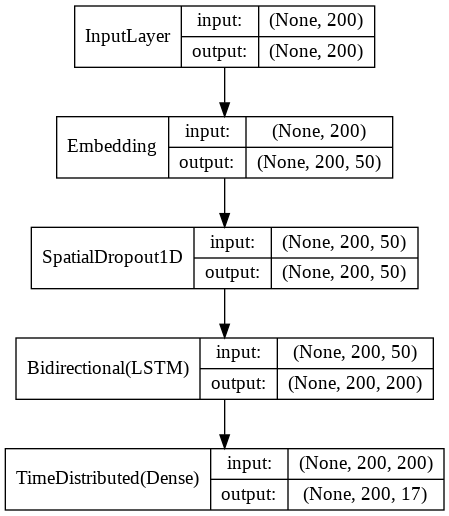

<Figure size 72x72 with 0 Axes>

In [0]:
from keras import regularizers


batch_size=32
word_input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(word_input)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)




model = Model(word_input, out)
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()
from keras.utils import plot_model
from matplotlib import pyplot as plt
plt.figure(figsize=(1,1))
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=False)

In [0]:
X_tr= X_tr[:6*batch_size]
y_tr = y_tr[:6*batch_size]

In [0]:
print(class_weights)

[ 3.77881345 27.57352941 14.23149905  9.38673342  8.56653341 25.39145154
 13.4198166   0.09853188 21.78649237  0.18665248  7.67263427 11.06398672
  5.54067781 15.34526854  9.41176471 12.60504202 11.45912911]


In [0]:
history = model.fit(X_tr,  y_tr.reshape(*y_tr.shape, 1), epochs=100,verbose=1,batch_size=32,class_weight=class_weights)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





192/192 [==============================] - 4s 21ms/step - loss: 2.1690 - acc: 0.5246
Epoch 2/100
192/192 [==============================] - 2s 9ms/step - loss: 0.7392 - acc: 0.7739
Epoch 3/100
192/192 [==============================] - 2s 9ms/step - loss: 0.5861 - acc: 0.8742
Epoch 4/100
192/192 [==============================] - 2s 9ms/step - loss: 0.5416 - acc: 0.8828
Epoch 5/100
192/192 [==============================] - 2s 9ms/step - loss: 0.5223 - acc: 0.8878
Epoch 6/100
192/192 [==============================] - 2s 9ms/step - loss: 0.4933 - acc: 0.8974
Epoch 7/100
192/192 [==============================] - 2s 9ms/step - loss: 0.4798 - acc: 0.9017
Epoch 8/100
192/192 [==============================] - 2s 8ms/step - loss: 0.4664 - acc: 0.9047
Epoch 9/100
192/192 [==============================] - 2s 9ms/step - loss: 0.4608 - acc: 0.9054
Epoch 10/100
192/192 [===========

In [0]:
X_te= X_te[:2*batch_size]
y_te = y_te[:2*batch_size]

#batch_size=32
i= np.random.randint(0,len(X_te)/2)
print(i)
p = model.predict(np.array(X_te[7:7+batch_size]), verbose=1)[0]

#print(p)
for i in p:
  #print (i)
  p2 = np.argmax(p, axis=-1)
print(p2)

27
32/32 [==============================] - 0s 9ms/step
[ 9  9  9  9  9  9  9 16  0 16  9  9  9  9  9  9  9  9  9  0 11  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9 12  9  9  9  9  9  9  9  9  9
  9 12  0  9 15 15  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 16  9  9  9  9 12  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9 11  9  9  9  4  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  0  9
  9  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7]


In [0]:

batch_size=32
X_te= X_te[:2*batch_size]
y_te = y_te[:2*batch_size]
print(len(X_te))
pred_cat = model.predict(np.array(X_te))
pred = np.argmax(pred_cat, axis=-1)
#y_te_true = np.argmax(y_te, -1)


64


In [0]:
print(pred)

[[9 9 9 ... 7 7 7]
 [9 9 9 ... 7 7 7]
 [9 9 9 ... 7 7 7]
 ...
 [9 9 9 ... 7 7 7]
 [9 9 9 ... 7 7 7]
 [9 9 0 ... 7 7 7]]


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}
#idx2word = {i: w for w, i in word2idx.items()}
print(idx2tag)
idx2word = {i: w for w, i in word2idx.items()}
print(idx2word)

{0: 'B-trigger', 1: 'B-fname', 2: 'B-etime', 3: 'I-fname', 4: 'B-organizer', 5: 'B-loc', 6: 'I-loc', 7: 'I-place', 8: 'I-participant', 9: 'O', 10: 'I-organizer', 11: 'B-place', 12: 'B-participant', 13: 'I-target', 14: 'B-target', 15: 'I-trigger', 16: 'I-etime'}
{0: 'Stadium', 1: 'dastardly', 2: 'raids', 3: 'minorities', 4: 'rallies', 5: 'Md.', 6: 'Chowdhury', 7: 'KOZHIKODE', 8: 'GVK-EMRI', 9: 'position', 10: 'Residents', 11: 'hand-chopping', 12: 'outfit', 13: 'amicable', 14: 'local', 15: 'Auxiliary', 16: 'boarded', 17: 'up', 18: 'stalemate', 19: 'broadcasting', 20: 'allegation', 21: 'Evicted', 22: '5', 23: 'relay', 24: 'Mahadev', 25: 'property', 26: 'October', 27: 'fisticuffs', 28: 'Kanwaldeep', 29: 'Fest', 30: 'Rane', 31: 'device', 32: 'deployments', 33: 'consciousness', 34: 'rifles', 35: 'credence', 36: 'detained', 37: 'discovery', 38: 'PFI', 39: 'surge', 40: 'Majumder', 41: 'view', 42: 'desecration', 43: 'communicable', 44: 'Eanchakkal', 45: 'Association', 46: 'zindabad', 47: 'colle

In [0]:
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for i in range (0,len(X_te)):
  
  print("-------------------------------------------")
  print(i)
  for w, true, prd in zip(X_te[i], y_te[i], pred[i]):
    if idx2word[w] != "Stadium":
        print("{:15}:{:5} ({})".format(idx2word[w] , idx2tag[true], idx2tag[prd]))

Word           (True ): Pred
-------------------------------------------
0
SAMPLE_START   :O     (O)
May            :B-etime (O)
Day            :I-etime (O)
flags          :B-trigger (O)
were           :I-trigger (O)
hoisted        :I-trigger (B-trigger)
by             :O     (O)
workers        :B-participant (I-fname)
and            :O     (O)
union          :B-organizer (I-fname)
activists      :B-participant (B-participant)
at             :O     (O)
various        :O     (I-trigger)
places         :O     (O)
in             :O     (O)
the            :O     (O)
city           :O     (O)
including      :O     (O)
some           :O     (O)
auto-rickshaw  :B-loc (B-place)
stands         :I-loc (B-loc)
.              :O     (O)
-------------------------------------------
1
SAMPLE_START   :O     (O)
NEW            :O     (O)
DELHI          :O     (O)
:              :O     (O)
Chidambaram    :O     (O)
:              :O     (O)
none           :O     (O)
should         :O     (O)
support    

In [0]:
! pip install  sklearn_crfsuite

     |████████████████████████████████| 757kB 5.1MB/s 


In [0]:
from sklearn_crfsuite.metrics import flat_classification_report
idx2tag = {i: w for w, i in tag2idx.items()}
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

               precision    recall  f1-score   support

      B-etime       0.60      0.30      0.40        61
      B-fname       0.33      0.10      0.15        41
        B-loc       0.00      0.00      0.00        27
  B-organizer       0.71      0.20      0.31       112
B-participant       0.43      0.36      0.39       159
      B-place       0.28      0.17      0.21        69
     B-target       0.09      0.05      0.07        79
    B-trigger       0.58      0.52      0.55       218
      I-etime       0.49      0.34      0.40        71
      I-fname       0.27      0.08      0.13       131
        I-loc       0.19      0.11      0.14        63
  I-organizer       0.80      0.11      0.20       142
I-participant       0.14      0.03      0.04        38
      I-place       1.00      1.00      1.00      6969
     I-target       0.18      0.04      0.07        49
    I-trigger       0.14      0.18      0.16        60
            O       0.84      0.95      0.89      4511

     acc

In [0]:
!pip install eli5
import eli5

     |████████████████████████████████| 112kB 3.5MB/s 


In [0]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler

In [0]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, word2idx, tag2idx, max_len):
        self.model = model
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.idx2tag = {v: k for k,v in tag2idx.items()}
        self.max_len = max_len
        
    def _preprocess(self, texts):
        X = [[self.word2idx.get(w, self.word2idx["UNK"]) for w in t.split()]
             for t in texts]
        X = pad_sequences(maxlen=self.max_len, sequences=X,
                          padding="post", value=self.word2idx["PAD"])
        return X
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func

In [0]:
print(tags)

['B-trigger', 'B-fname', 'B-etime', 'I-fname', 'B-organizer', 'B-loc', 'I-loc', 'I-place', 'I-participant', 'O', 'I-organizer', 'B-place', 'B-participant', 'I-target', 'B-target', 'I-trigger', 'I-etime']


In [0]:
labels = [[s[1] for s in sent] for sent in sentences]
sentences1 = [" ".join([s[0] for s in sent]) for sent in sentences]
print(len(sentences1))
print(sentences1)

300
['SAMPLE_START KRISHNAGIRI / DHARMAPURI : Water supply disrupted , villagers block road September 04 , 2014 00:00 IST Officials promise to supply water in tankers Women took to streets carrying pots in protest against erratic supply of drinking water at Kelamagalam in Udhanapalli on Wednesday . [SEP] The protesters blocked the Rayakottai road .', "SAMPLE_START KARNATAKA Arrest Muthalik , ban sene : PFI May 16 , 2010 00:00 IST Staff Correspondent Udupi : Leaders of various organisations who participated in a dharna organised by the district unit of Popular Font of India in front of the Deputy Commissioner 's office here on Saturday urged the Union Government to initiate immediate legal action against the leader of the Sri Rama Sene , Pramod Muthalk , and his followers .", 'SAMPLE_START KERALA Healthy protest For better care : BJP councillors sitting on a dharna on Friday in front of the Palakkad municipal office demanding urgent steps for sanitation , cleaning , and waste management

In [0]:
for i,j in enumerate(sentences1):
  if "May Day flags were hoisted" in j:
    print(j)
    print(i)
  

SAMPLE_START May Day flags were hoisted by workers and union activists at various places in the city including some auto-rickshaw stands .
164


In [0]:
for i,j in enumerate(sentences1):
  if "Resenting the arrests" in j:
    print(j)
    print(i)



SAMPLE_START Resenting the arrests , the activists staged rasta roko before NTR statue and before the Kurnool III Town police station for some time .
271


In [0]:
for i,j in enumerate(sentences1):
  if "Spot where they" in j:
    print(j)
    print(i)


SAMPLE_START Spot where they got on bus turns protest venue - Indian Express Aditi Vatsa , Aditi Vatsa : New Delhi , Sun Dec 30 2012 , 01:17 hrs Mourning the death of the 23 - year-old gangrape victim and demanding strict punishment for the guilty , a large crowd gathered at Munirka bus stop , the same spot from she and her friend had boarded the chartered bus on that ill-fated night . [SEP] Apart from students and teachers of Jawaharlal Nehru University , many residents too gathered here after hearing about the protest on news channels . [SEP] JNU Students ' Union president V Lenin Kumar said , " This is a wake-up call for the government . [SEP] If it does not act , the protests will continue . " [SEP] The bus stop walls were soon covered with posters , many of them exhorting people to " continue the struggle against patriarchy so that every woman can live a life free of violence " .
68


In [0]:

for i,j in enumerate(sentences1):
  if "Police suspect that the panchayat members" in j:
    print(j)
    print(i)

SAMPLE_START Salwa Judum leader among 3 killed in Bastar - Indian Express Express News Service , Express News Service : RAIPUR : , Tue Jul 01 2008 , 23:26 hrs Suspected Maoist rebels killed a Salwa Judum leader and two elected panchayat members . [SEP] Police suspect that the panchayat members , including the Salwa Judum leader , were abducted and killed by Maoist rebels , who had left the bodies near the village .
218


In [0]:

sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
index = 271
label = labels[index]
text = sentences[index]
print(text)
print()
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label)]))

SAMPLE_START Resenting the arrests , the activists staged rasta roko before NTR statue and before the Kurnool III Town police station for some time .

SAMPLE_START (O) Resenting (O) the (O) arrests (O) , (O) the (O) activists (B-participant) staged (O) rasta (B-trigger) roko (I-trigger) before (B-fname) NTR (I-fname) statue (I-fname) and (O) before (B-fname) the (I-fname) Kurnool (I-fname) III (I-fname) Town (I-fname) police (I-fname) station (I-fname) for (O) some (O) time (O) . (O)


In [0]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")

0: SAMPLE_START
1: Resenting
2: the
3: arrests
4: ,
5: the
6: activists
7: staged
8: rasta
9: roko
10: before
11: NTR
12: statue
13: and
14: before
15: the
16: Kurnool
17: III
18: Town
19: police
20: station
21: for
22: some
23: time
24: .


In [0]:
explainer_generator = NERExplainerGenerator(model, word2idx, tag2idx, max_len)

In [0]:
word_index = 16
predict_func = explainer_generator.get_predict_function(word_index=word_index)

In [0]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)

In [0]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values()),
    top_targets=4
)

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5,\n              random_state=<mtrand.RandomState object at 0x7f930f635e58>,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='I-fname', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[15] Kurnool', weight=4.332136622261866, std=None, value=1.0), FeatureWeight(feature='[11] statue', weight=2.7069130160888255, std=None, value=1.0), FeatureWeight(feature='[16] III', weight=0.8159772873877467, std=None, value=1.0), FeatureWeight(feature='[14] the', weight=0.6858141884001874, std=None, value=1.0), FeatureWeight(feature='[18] police', weight=0.23222129487563634, std=None, value=1.0), FeatureWeight(feature='[6] staged', weight=0.20298361371250778, std=None, value=1.0), FeatureWeight(feature='[17] Town', weight=0.14510591764500377, std=None, value=1.0), FeatureWeight(feature='[19] station', weight=0.11026547332086692, std=None, value=1.0), FeatureWeight(feature='[1] Resenting', weight=0.09931280975457023, std=None, value=1.0), FeatureWeight(feature='[7] rasta', weight=0.056217290549785054, std=None, value=1.0), FeatureWeight(feature='[2] the', weight=0.005243532505441187, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.954612216558432, std=None, value=1.0), FeatureWeight(feature='[8] roko', weight=-1.2698070705520683, std=None, value=1.0), FeatureWeight(feature='[10] NTR', weight=-0.844396463023737, std=None, value=1.0), FeatureWeight(feature='[12] and', weight=-0.6733162184221972, std=None, value=1.0), FeatureWeight(feature='[9] before', weight=-0.44145677675596356, std=None, value=1.0), FeatureWeight(feature='[0] SAMPLE_START', weight=-0.29921998782990966, std=None, value=1.0), FeatureWeight(feature='[21] some', weight=-0.27013756502578906, std=None, value=1.0), FeatureWeight(feature='[5] activists', weight=-0.18704399073609218, std=None, value=1.0), FeatureWeight(feature='[22] time', weight=-0.17493048212649476, std=None, value=1.0), FeatureWeight(feature='[20] for', weight=-0.14697167459555813, std=None, value=1.0), FeatureWeight(feature='[4] the', weight=-0.14395421449341847, std=None, value=1.0), FeatureWeight(feature='[3] arrests', weight=-0.08612793191488509, std=None, value=1.0), FeatureWeight(feature='[13] before', weight=-0.06853474305505769, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.7475723385591035, score=0.8316817114128336, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='SAMPLE_START Resenting the arrests , the activists staged rasta roko before NTR statue and before the Kurnool III Town police station for some time .', spans=[('SAMPLE_START', [(0, 12)], -0.29921998782990966), ('Resenting', [(13, 22)], 0.09931280975457023), ('the', [(23, 26)], 0.005243532505441187), ('arrests', [(27, 34)], -0.08612793191488509), ('the', [(37, 40)], -0.14395421449341847), ('activists', [(41, 50)], -0.18704399073609218), ('staged', [(51, 57)], 0.20298361371250778), ('rasta', [(58, 63)], 0.056217290549785054), ('roko', [(64, 68)], -1.2698070705520683), ('before', [(69, 75)], -0.44145677675596356), ('NTR', [(76, 79)], -0.844396463023737), ('statue', [(80, 86)], 2.7069130160888255), ('and', [(87, 90)], -0.6733162184221972), ('before', [(91, 97)], -0.06853474305505769), ('the', [(98, 101)], 0.6858141884001874), ('Kurnool', [(102, 109)], 4.332136622261866), ('III', [(110, 113)], 0.8159772873877467), ('Town', [(114, 118)], 0.14510591764500377), ('police', [(119, 125)], 0.23222129487563634), ('station', [(126, 133)], 0.11026547332086692), ('for', [(134, 137)

In [0]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42
)

te.fit(text, predict_func)

te.explain_prediction(  target_names=list(explainer_generator.idx2tag.values()),
    targets=['O','I-place', 'B-target']
   
  )

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5,\n              random_state=<mtrand.RandomState object at 0x7f930f80cc18>,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[8] roko', weight=3.5552281184057217, std=None, value=1.0), FeatureWeight(feature='[9] before', weight=1.1890411543637667, std=None, value=1.0), FeatureWeight(feature='[4] the', weight=1.0071254792849211, std=None, value=1.0), FeatureWeight(feature='[0] SAMPLE_START', weight=0.5560687834101651, std=None, value=1.0), FeatureWeight(feature='[3] arrests', weight=0.33398989640760357, std=None, value=1.0), FeatureWeight(feature='[5] activists', weight=0.31094525301095505, std=None, value=1.0), FeatureWeight(feature='[2] the', weight=0.11279129288431376, std=None, value=1.0), FeatureWeight(feature='[14] the', weight=0.09775601582781934, std=None, value=1.0), FeatureWeight(feature='[13] before', weight=0.06184971537856222, std=None, value=1.0)], neg=[FeatureWeight(feature='[10] NTR', weight=-3.418804716964, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-2.106039767157105, std=None, value=1.0), FeatureWeight(feature='[6] staged', weight=-1.2099810353001341, std=None, value=1.0), FeatureWeight(feature='[7] rasta', weight=-0.7765074570502924, std=None, value=1.0), FeatureWeight(feature='[11] statue', weight=-0.19769735951914763, std=None, value=1.0), FeatureWeight(feature='[12] and', weight=-0.11016300855455657, std=None, value=1.0), FeatureWeight(feature='[20] for', weight=-0.10405758772607969, std=None, value=1.0), FeatureWeight(feature='[1] Resenting', weight=-0.07080739811148622, std=None, value=1.0), FeatureWeight(feature='[22] time', weight=-0.06729341412611471, std=None, value=1.0), FeatureWeight(feature='[21] some', weight=-0.027587683612034425, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.3006594214361491, score=-0.8641437191471213, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='SAMPLE_START Resenting the arrests , the activists staged rasta roko before NTR statue and before the Kurnool III Town police station for some time .', spans=[('SAMPLE_START', [(0, 12)], 0.5560687834101651), ('Resenting', [(13, 22)], -0.07080739811148622), ('the', [(23, 26)], 0.11279129288431376), ('arrests', [(27, 34)], 0.33398989640760357), ('the', [(37, 40)], 1.0071254792849211), ('activists', [(41, 50)], 0.31094525301095505), ('staged', [(51, 57)], -1.2099810353001341), ('rasta', [(58, 63)], -0.7765074570502924), ('roko', [(64, 68)], 3.5552281184057217), ('before', [(69, 75)], 1.1890411543637667), ('NTR', [(76, 79)], -3.418804716964), ('statue', [(80, 86)], -0.19769735951914763), ('and', [(87, 90)], -0.11016300855455657), ('before', [(91, 97)], 0.06184971537856222), ('the', [(98, 101)], 0.09775601582781934), ('for', [(134, 137)], -0.10405758772607969), ('some', [(138, 142)], -0.027587683612034425), ('time', [(143, 147)], -0.06729341412611471)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=1.2418960480099825, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-2.106039767157105, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)), heatmap=None), TargetExplanation(target='I-place', feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-5.790813123482835, std=None, value=1.0), FeatureWeight(feature='[8] roko', weight=-0.21428893269571578, std=None